# Part A: Segmentation of Water Channels to Measure Water Contamination Due to Trash


Part A serves as a skeleton code to visualize the performance of any trained model for water channel segmentation on any dataset.

Mounted at /content/drive


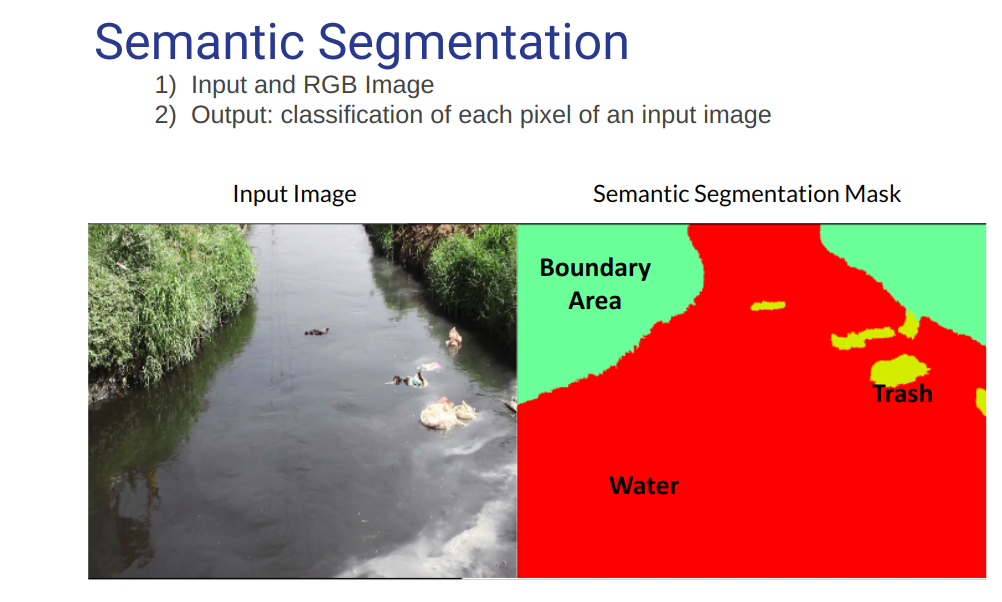

In [ ]:
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
drive.mount('/content/drive',force_remount=True)
a_png = cv2.imread('/content/drive/My Drive/PA2/a.png')
cv2_imshow(a_png)

In [ ]:

import os, sys
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, Activation, Reshape, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, UpSampling2D, concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
from keras.utils import plot_model, to_categorical
import keras.backend as K
from keras.utils import  to_categorical
import keras
from keras import optimizers
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard


In [ ]:


Beta=[0.011676873, 0.869083715, 0.119239412]
Beta= np.array(Beta)
# print(Beta)
def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

def blance_loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight =Beta
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=pos_weight)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss *(Beta))


#Model
inputs = Input((256,256,3))
conv1 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
conv5 = SeparableConv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = SeparableConv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = SeparableConv2D(3, 3, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv9)

model = Model(inputs,conv9)
model.compile(optimizer = Adam(lr = 1e-4), loss =blance_loss, metrics = ['accuracy'])



In [ ]:
model.load_weights('/content/drive/MyDrive/model.h5')

In [ ]:
import matplotlib.pyplot as plt
def predict_(input_img):
    input_ = np.array(cv2.imread(str(input_img)))
    input_ = cv2.resize(input_, (256, 256), interpolation=cv2.INTER_NEAREST)
    input_ = input_ / 255
    fig, axs = plt.subplots(1, 2, figsize=(6, 6))
    axs[0].imshow(input_)
    axs[0].set_title('Actual Image')
    axs[0].axis('off')
    pre = model.predict(input_.reshape(1, 256, 256, 3))
    pre = pre.reshape(256, 256, 3)
    pre = np.argmax(pre, axis=-1)
    label = keras.utils.to_categorical(pre, 3)
    label[:, :, 0] = label[:, :, 1]
    label[:, :, 2] = label[:, :, 1]
    axs[1].imshow(label)
    axs[1].set_title('Predicted Image')
    axs[1].axis('off')
    plt.show()




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_file_path = '/content/drive/My Drive/5000 sementic dataset/5000 Sementic Segmentation-20230926T200640Z-001.zip'
extraction_dir = '/content/dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)


1/1 [==============================] - 3s 3s/step


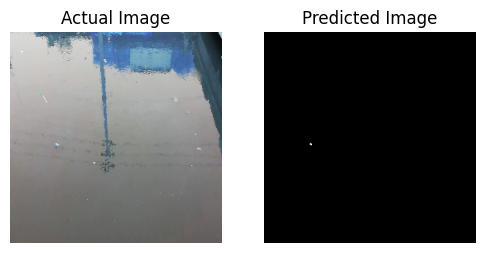

1/1 [==============================] - 1s 1s/step


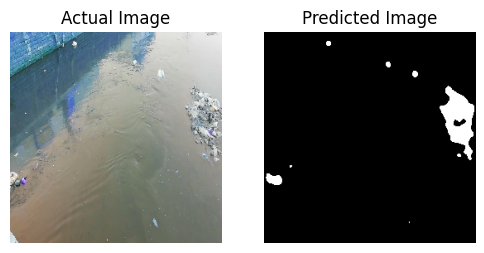

1/1 [==============================] - 1s 1s/step


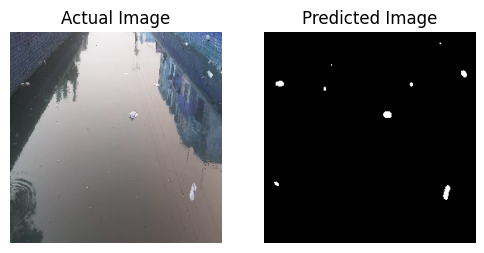

1/1 [==============================] - 1s 1s/step


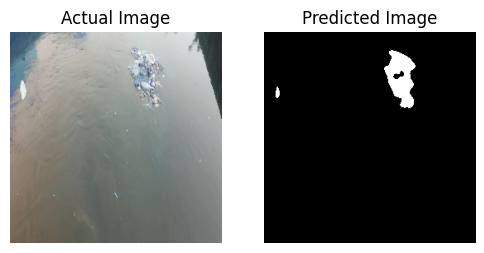

1/1 [==============================] - 1s 735ms/step


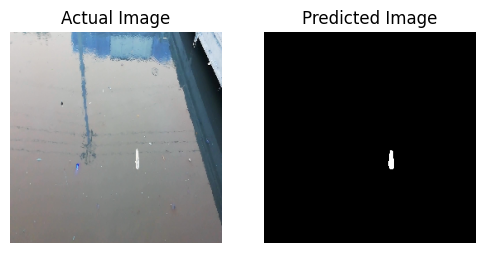

1/1 [==============================] - 1s 769ms/step


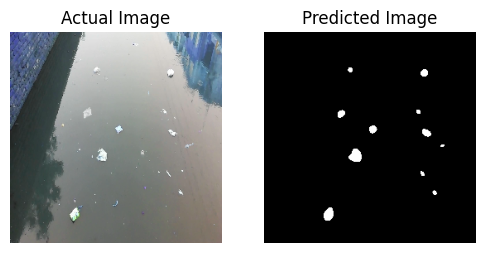

1/1 [==============================] - 1s 759ms/step


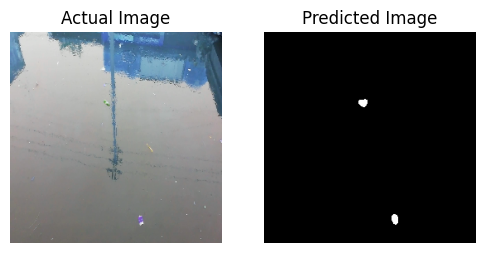

1/1 [==============================] - 1s 737ms/step


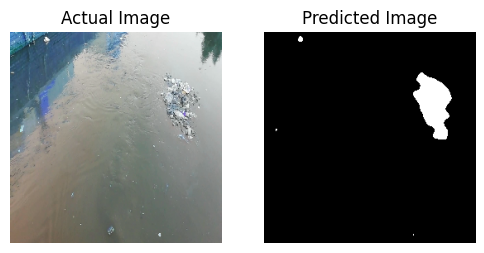

1/1 [==============================] - 1s 742ms/step


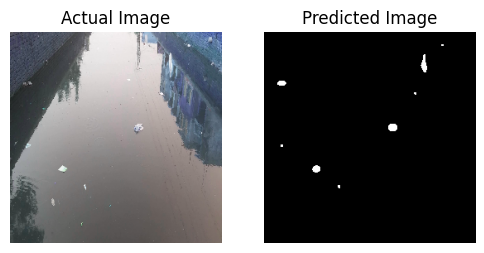

1/1 [==============================] - 1s 753ms/step


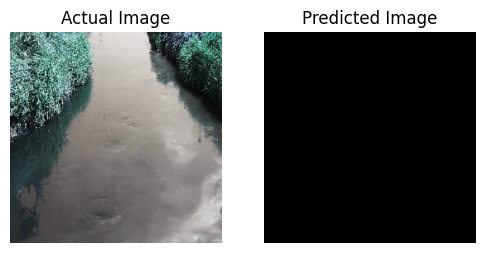

1/1 [==============================] - 1s 754ms/step


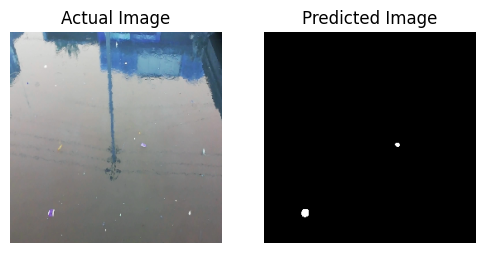

1/1 [==============================] - 1s 742ms/step


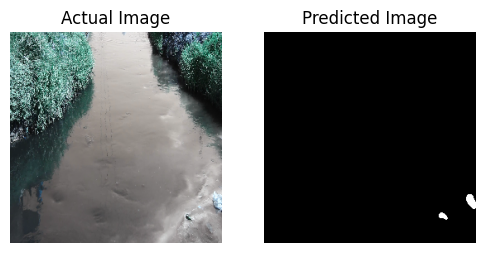

In [ ]:

images = [os.path.join('/content/dataset/5000 Sementic Segmentation/new_x_', filename) for filename in os.listdir('/content/dataset/5000 Sementic Segmentation/new_x_')]

for i, image_path in enumerate(images):
    predict_(image_path)
    if i == 11:
        break



# Part B: Building a Compact Model for Water Channel Segmentation to Measure Water Contamination Due to Trash**


In this Task, we will segment water channels in images to measure water contamination caused by trash. Our goal is to create a opptimized and small neural network model with fewer parameters while maintaining segmentation accuracy. 

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_image(image):
    image = cv2.resize(image, (100, 100))
    return image

def preprocess_label(label):
    quantized_label = np.zeros_like(label, dtype=np.uint8)
    quantized_label[label < 25] = 0
    quantized_label[(label >= 25) & (label < 50)] = 1
    quantized_label[label >= 50] = 2
    return quantized_label

def getData(data_dir):
    images = []
    labels = []

    for filename in os.listdir(os.path.join(data_dir, 'new_x_')):
        image_path = os.path.join(data_dir, 'new_x_', filename)
        label_path = os.path.join(data_dir, 'new_y_', filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = preprocess_image(image)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        label = preprocess_image(label)
        label = preprocess_label(label)

        images.append(image)
        labels.append(label)

    X = np.array(images)
    y=np.array(labels)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = getData('/content/dataset/5000 Sementic Segmentation')



[0 1 2]


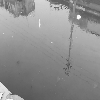

In [ ]:
print(np.unique(y_test[0]))
cv2_imshow(X_train[3])

In [ ]:
print(np.unique(y_test))

[0 1 2]


In [228]:
import cv2
import numpy as np

def visualize_preprocessed_image(preprocessed_image):
    finalImage=preprocessed_image
    finalImage = finalImage.astype(np.uint8)
    if len(finalImage.shape) == 2:
        finalImage = cv2.cvtColor(finalImage, cv2.COLOR_GRAY2BGR)
    return finalImage


(100, 100, 3)


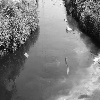

In [229]:
im=visualize_preprocessed_image(X_train[10])
print(im.shape)
cv2_imshow(im)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(100, 100, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), padding='same', activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
epochs = 12
batch_size = 32

history = model.fit( X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
                    batch_size=batch_size,
                    verbose=1
)


Epoch 1/12
117/117 [==============================] - 276s 2s/step - loss: 0.0295 - accuracy: 0.9900 - val_loss: 0.0298 - val_accuracy: 0.9899
Epoch 2/12
117/117 [==============================] - 276s 2s/step - loss: 0.0276 - accuracy: 0.9907 - val_loss: 0.0279 - val_accuracy: 0.9904
Epoch 3/12
117/117 [==============================] - 277s 2s/step - loss: 0.0260 - accuracy: 0.9911 - val_loss: 0.0267 - val_accuracy: 0.9908
Epoch 4/12
117/117 [==============================] - 275s 2s/step - loss: 0.0252 - accuracy: 0.9914 - val_loss: 0.0262 - val_accuracy: 0.9910
Epoch 5/12
117/117 [==============================] - 277s 2s/step - loss: 0.0246 - accuracy: 0.9915 - val_loss: 0.0259 - val_accuracy: 0.9911
Epoch 6/12
117/117 [==============================] - 271s 2s/step - loss: 0.0239 - accuracy: 0.9917 - val_loss: 0.0256 - val_accuracy: 0.9913
Epoch 7/12
117/117 [==============================] - 273s 2s/step - loss: 0.0233 - accuracy: 0.9919 - val_loss: 0.0248 - val_accuracy: 0.9914

In [ ]:
y_pred=model.predict(y_test)
print(y_pred.shape)

26/26 [==============================] - 12s 453ms/step
(803, 100, 100, 3)


In [ ]:
print(y_test.shape)

(803, 100, 100)


In [174]:
import numpy as np

def classify_ranges(y_pred, num_classes):
    unique_values = np.unique(y_pred)
    sorted_values = np.sort(unique_values)
    percentiles = np.percentile(sorted_values, [0, 33.33, 66.66, 100])
    class_labels = np.digitize(y_pred, percentiles) - 1
    return class_labels

def calculate_iou(y_true, y_pred, class_index, num_classes):
    y_true = (y_true == class_index).astype(np.uint8)
    y_pred = classify_ranges(y_pred, num_classes)
    y_pred = (y_pred == class_index).astype(np.uint8)
    y_pred = np.argmax(y_pred, axis=-1)
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / (np.sum(union) + 1e-5)
    return iou

def calculate_dice_coefficient(y_true, y_pred, class_index, num_classes):
    y_true = (y_true == class_index).astype(np.uint8)
    y_pred = classify_ranges(y_pred, num_classes)
    y_pred = (y_pred == class_index).astype(np.uint8)
    y_pred = np.argmax(y_pred, axis=-1)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice_coefficient = (2.0 * intersection) / (union + 1e-5)
    return dice_coefficient

num_classes = 3
iou_scores = []
dice_scores = []

for class_index in range(num_classes):
    class_iou_scores = [calculate_iou(y_test[i], y_pred[i], class_index, num_classes) for i in range(len(y_test))]
    class_dice_scores = [calculate_dice_coefficient(y_test[i], y_pred[i], class_index, num_classes) for i in range(len(y_test))]
    iou_scores.append(np.mean(class_iou_scores))
    dice_scores.append(np.mean(class_dice_scores))

avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)

print(f"Average IoU: {avg_iou:.2f}")
print(f"Average Dice Coefficient: {avg_dice:.2f}")


# Dear TA, increase number of epochs to gain maximum scores.


Average IoU: 0.76
Average Dice Coefficient: 0.82


In [ ]:
segmented = model.predict(X_test)

In [ ]:
import cv2
import numpy as np

def visualize_final_image(predicted_image):

    class_colors = {
        0: (0, 128, 0), 1: (128, 128, 0),  2: (0, 0, 128) }
    class_indices = np.argmax(predicted_image, axis=-1)
    height, width = class_indices.shape
    colored_image = np.zeros((height, width, 3), dtype=np.uint8)
    for class_index, color in class_colors.items():
        colored_image[class_indices == class_index] = color

    return colored_image


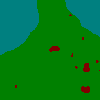

In [176]:
i=visualize_final_image(segmented[50])
cv2_imshow(i)

In [178]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 50, 50, 64)      